In [ ]:
from neo4j import GraphDatabase
import random
import warnings
warnings.filterwarnings('ignore')

def ensure_node_ids(tx):
    """
    Ensures all nodes in the Neo4j graph have a 'node_id' property.
    """
    tx.run("""
    CALL apoc.periodic.iterate(
        'MATCH (n) WHERE n.node_id IS NULL RETURN n',
        'SET n.node_id = apoc.create.uuid()',
        {batchSize: 1000}
    )
    """)
def set_default_probabilities(tx):
    """
    Sets a default probability value for relationships that lack it.
    """
    tx.run("""
    MATCH ()-[r]->()
    WHERE r.probability IS NULL
    SET r.probability = 1.0
    """)
def random_walk_markov(tx, start_node_id, length):
    """
    Performs a Markov Chain-based random walk on a Neo4j graph.

    Args:
        tx: Transaction object for Neo4j.
        start_node_id: Starting node's 'node_id'.
        length: Length of the random walk.

    Returns:
        List of node IDs visited during the random walk.
    """
    walk = [start_node_id]
    current_node_id = start_node_id

    for _ in range(length):
        result = tx.run(
            """
            MATCH (n {node_id: $current_node_id})-[r]->(neighbor)
            RETURN neighbor.node_id AS neighbor_id, r.probability AS probability
            """,
            current_node_id=current_node_id
        )
        neighbors = [
            (record['neighbor_id'], record['probability'] if record['probability'] is not None else 1.0)
            for record in result
        ]

        if neighbors:
            # Weighted random choice based on probabilities
            neighbor_ids, probabilities = zip(*neighbors)
            next_node_id = random.choices(neighbor_ids, weights=probabilities, k=1)[0]
            walk.append(next_node_id)
            current_node_id = next_node_id
        else:
            # Fallback: Pick a random node
            result = tx.run("MATCH (n) RETURN n.node_id AS node_id SKIP toInteger(rand() * 10) LIMIT 1")
            fallback_node = result.single()
            if fallback_node:
                walk.append(fallback_node['node_id'])
                current_node_id = fallback_node['node_id']
            else:
                break

    return walk
def create_subgraph(tx, random_walk_path):
    """
    Writes the random walk path into Neo4j as "WALK_TO" relationships with metadata.

    Args:
        tx: Transaction object for Neo4j.
        random_walk_path: List of node IDs representing the random walk path.
    """
    for i in range(len(random_walk_path) - 1):
        tx.run(
            """
            MATCH (a {node_id: $start_id}), (b {node_id: $end_id})
            MERGE (a)-[r:WALK_TO]->(b)
            SET r.step = $step
            """,
            start_id=random_walk_path[i],
            end_id=random_walk_path[i + 1],
            step=i
        )
# Neo4j connection details
uri = "bolt://localhost:7476"  # Default Bolt port for Neo4j
user = "neo4j"
password = "xxxxxxx"  # Replace with your actual password

with GraphDatabase.driver(uri, auth=(user, password)) as driver:
    with driver.session() as session:
        # Ensure all nodes have 'node_id' property
        print("Ensuring all nodes have a 'node_id' property...")
        session.execute_write(ensure_node_ids)

        # Set default probabilities for relationships
        print("Setting default probabilities for relationships...")
        session.execute_write(set_default_probabilities)

        # Perform a Markov Chain-based random walk
        start_node_id = 1  # Replace with the starting node ID
        walk_length = 200   # Length of the random walk
        print(f"Performing a Markov Chain-based random walk starting from node_id {start_node_id}...")
        random_walk_path = session.execute_write(random_walk_markov, start_node_id, walk_length)
        print(f"Markov Chain Random Walk Path: {random_walk_path}")

        # Write the random walk as a subgraph with "WALK_TO" relationships
        print("Creating subgraph for the random walk...")
        session.execute_write(create_subgraph, random_walk_path)

        print("Markov Chain random walk subgraph with 'WALK_TO' relationships created successfully.")



Ensuring all nodes have a 'node_id' property...
Setting default probabilities for relationships...
Performing a Markov Chain-based random walk starting from node_id 1...
Markov Chain Random Walk Path: [1, 127, 4, 152, 1, 127, 9, 133, 2, 136, 4, 138, 9, 143, 4, 133, 1, 122, 3, 151, 9, 122, 2, 127, 1, 131, 5, 138, 9, 143, 0, 121, 1, 127, 5, 138, 7, 133, 3, 122, 0, 129, 6, 143, 3, 138, 7, 133, 8, 120, 5, 122, 9, 143, 7, 152, 1, 127, 8, 120, 6, 143, 3, 138, 3, 122, 0, 124, 5, 122, 9, 143, 1, 127, 3, 122, 9, 122, 6, 124, 9, 133, 9, 133, 2, 136, 5, 138, 3, 138, 9, 133, 3, 122, 0, 129, 7, 152, 3, 122, 0, 121, 4, 152, 4, 138, 1, 131, 7, 121, 0, 121, 6, 143, 1, 127, 8, 122, 0, 129, 2, 127, 9, 143, 9, 133, 1, 127, 4, 133, 9, 122, 9, 133, 2, 136, 1, 127, 1, 122, 1, 127, 0, 129, 8, 122, 8, 120, 9, 143, 3, 151, 8, 135, 3, 122, 5, 133, 1, 127, 1, 131, 3, 122, 2, 136, 7, 121, 4, 152, 2, 127, 1, 131, 1, 131, 4, 133, 3, 122, 9, 133, 6, 143, 8, 120, 5, 133, 7, 121, 3, 151, 3, 151, 0, 121, 6, 124, 4, 138

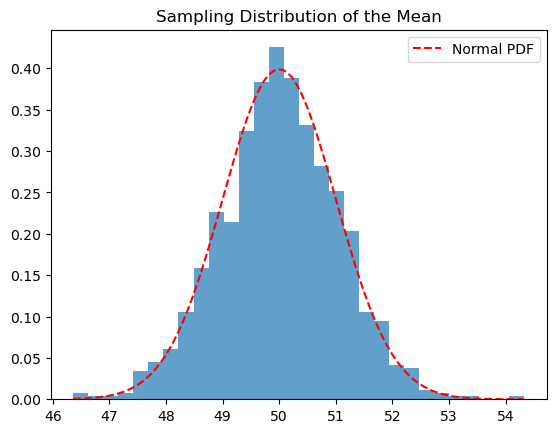

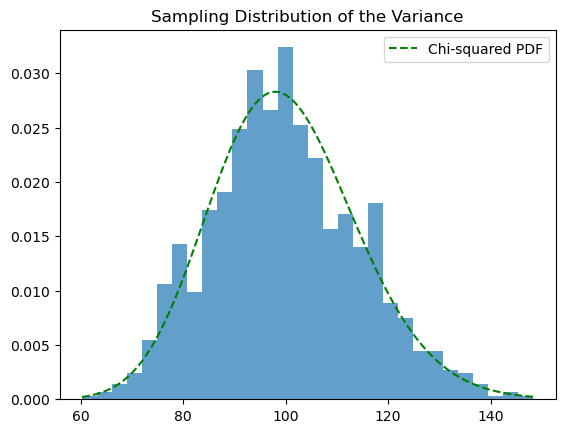

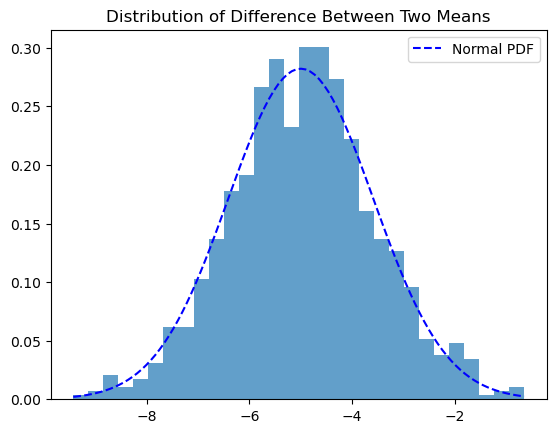

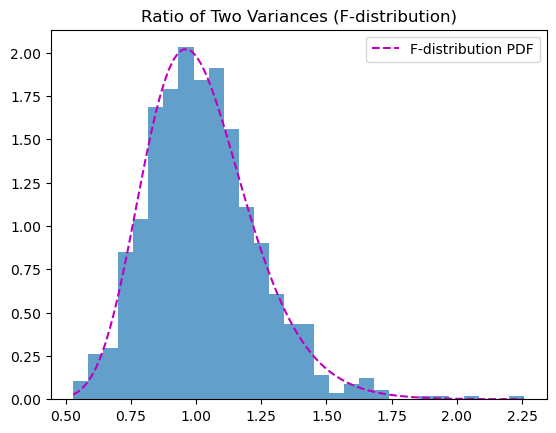

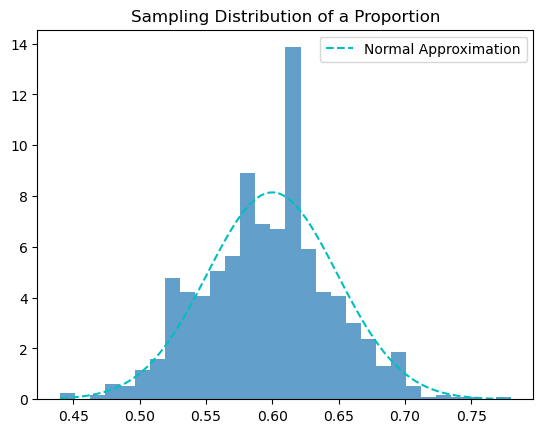

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set seed for reproducibility
np.random.seed(42)

# --- 1. Sampling Distribution of the Mean ---
pop_mean = 50
pop_std = 10
sample_size = 100
samples = [np.mean(np.random.normal(pop_mean, pop_std, sample_size)) for _ in range(1000)]

plt.figure()
plt.hist(samples, bins=30, density=True, alpha=0.7)
x = np.linspace(min(samples), max(samples), 100)
plt.plot(x, stats.norm.pdf(x, pop_mean, pop_std / np.sqrt(sample_size)), 'r--', label='Normal PDF')
plt.title("Sampling Distribution of the Mean")
plt.legend()
plt.show()

# --- 2. Sampling Distribution of the Variance ---
samples_var = [np.var(np.random.normal(pop_mean, pop_std, sample_size), ddof=1) for _ in range(1000)]

plt.figure()
plt.hist(samples_var, bins=30, density=True, alpha=0.7)
x = np.linspace(min(samples_var), max(samples_var), 100)
chi2_df = sample_size - 1
plt.plot(x, stats.chi2.pdf((chi2_df * x) / (pop_std ** 2), df=chi2_df) * (chi2_df / (pop_std ** 2)),
         'g--', label='Chi-squared PDF')
plt.title("Sampling Distribution of the Variance")
plt.legend()
plt.show()

# --- 3. Difference Between Two Means ---
mu1, mu2 = 50, 55
std1, std2 = 10, 10
n1, n2 = 100, 100
diff_means = [np.mean(np.random.normal(mu1, std1, n1)) - np.mean(np.random.normal(mu2, std2, n2)) for _ in range(1000)]

plt.figure()
plt.hist(diff_means, bins=30, density=True, alpha=0.7)
x = np.linspace(min(diff_means), max(diff_means), 100)
plt.plot(x, stats.norm.pdf(x, mu1 - mu2, np.sqrt(std1**2/n1 + std2**2/n2)), 'b--', label='Normal PDF')
plt.title("Distribution of Difference Between Two Means")
plt.legend()
plt.show()

# --- 4. Ratio of Two Variances (F-distribution) ---
var_ratios = [np.var(np.random.normal(mu1, std1, n1), ddof=1) /
              np.var(np.random.normal(mu2, std2, n2), ddof=1) for _ in range(1000)]

plt.figure()
plt.hist(var_ratios, bins=30, density=True, alpha=0.7)
x = np.linspace(min(var_ratios), max(var_ratios), 100)
plt.plot(x, stats.f.pdf(x, dfn=n1-1, dfd=n2-1), 'm--', label='F-distribution PDF')
plt.title("Ratio of Two Variances (F-distribution)")
plt.legend()
plt.show()

# --- 5. Sampling Distribution of a Proportion ---
p = 0.6
n = 100
proportions = [np.mean(np.random.binomial(1, p, n)) for _ in range(1000)]

plt.figure()
plt.hist(proportions, bins=30, density=True, alpha=0.7)
x = np.linspace(min(proportions), max(proportions), 100)
plt.plot(x, stats.norm.pdf(x, p, np.sqrt(p * (1 - p) / n)), 'c--', label='Normal Approximation')
plt.title("Sampling Distribution of a Proportion")
plt.legend()
plt.show()


In [14]:
import numpy as np
import plotly.graph_objects as go
import scipy.stats as stats

np.random.seed(42)
plots = []

# -----------------------------
# 1. Sampling Distribution of the Mean
# -----------------------------
# Population: Normal(50, 10)
pop_mean = 50
pop_std = 10
sample_size = 30

# Generate sample means
sample_means = [np.mean(np.random.normal(pop_mean, pop_std, sample_size)) for _ in range(1000)]

# Theoretical: Normal with same mean but smaller std
hist_data = np.histogram(sample_means, bins=30, density=True)
x_vals = np.linspace(min(sample_means), max(sample_means), 200)
pdf_vals = stats.norm.pdf(x_vals, pop_mean, pop_std / np.sqrt(sample_size))

fig1 = go.Figure()
fig1.add_trace(go.Bar(x=hist_data[1][:-1], y=hist_data[0], name="Sample Means", opacity=0.6))
fig1.add_trace(go.Scatter(x=x_vals, y=pdf_vals, mode='lines', name="Normal PDF (CLT)", line=dict(dash='dash')))
fig1.update_layout(title="1. Sampling Distribution of the Mean (Normal Shape, Symmetric)")
plots.append(fig1)

# -----------------------------
# 2. Sampling Distribution of the Variance
# -----------------------------
# Sample variances follow a chi-squared scaled distribution
sample_variances = [np.var(np.random.normal(pop_mean, pop_std, sample_size), ddof=1) for _ in range(1000)]

hist_data = np.histogram(sample_variances, bins=30, density=True)
x_vals = np.linspace(min(sample_variances), max(sample_variances), 200)
chi2_df = sample_size - 1
pdf_vals = stats.chi2.pdf((chi2_df * x_vals) / (pop_std ** 2), df=chi2_df) * (chi2_df / (pop_std ** 2))

fig2 = go.Figure()
fig2.add_trace(go.Bar(x=hist_data[1][:-1], y=hist_data[0], name="Sample Variances", opacity=0.6))
fig2.add_trace(go.Scatter(x=x_vals, y=pdf_vals, mode='lines', name="Chi-squared PDF", line=dict(dash='dash')))
fig2.update_layout(title="2. Sampling Distribution of the Variance (Right-Skewed, Chi-squared)")
plots.append(fig2)

# -----------------------------
# 3. Distribution of Difference Between Two Means
# -----------------------------
mu1, mu2 = 50, 55
std1, std2 = 10, 10
n1, n2 = 30, 30

# Sample differences in means
diff_means = [np.mean(np.random.normal(mu1, std1, n1)) - np.mean(np.random.normal(mu2, std2, n2)) for _ in range(1000)]

hist_data = np.histogram(diff_means, bins=30, density=True)
x_vals = np.linspace(min(diff_means), max(diff_means), 200)
pdf_vals = stats.norm.pdf(x_vals, mu1 - mu2, np.sqrt(std1**2/n1 + std2**2/n2))

fig3 = go.Figure()
fig3.add_trace(go.Bar(x=hist_data[1][:-1], y=hist_data[0], name="Difference of Means", opacity=0.6))
fig3.add_trace(go.Scatter(x=x_vals, y=pdf_vals, mode='lines', name="Normal PDF", line=dict(dash='dash')))
fig3.update_layout(title="3. Difference Between Two Means (Normal, Centered at μ1−μ2)")
plots.append(fig3)

# -----------------------------
# 4. Ratio of Two Variances (F-distribution)
# -----------------------------
# Sampling distribution of the ratio of two sample variances
f_ratios = [np.var(np.random.normal(mu1, std1, n1), ddof=1) /
            np.var(np.random.normal(mu2, std2, n2), ddof=1) for _ in range(1000)]

hist_data = np.histogram(f_ratios, bins=30, density=True)
x_vals = np.linspace(min(f_ratios), max(f_ratios), 200)
pdf_vals = stats.f.pdf(x_vals, dfn=n1-1, dfd=n2-1)

fig4 = go.Figure()
fig4.add_trace(go.Bar(x=hist_data[1][:-1], y=hist_data[0], name="Variance Ratios", opacity=0.6))
fig4.add_trace(go.Scatter(x=x_vals, y=pdf_vals, mode='lines', name="F-distribution PDF", line=dict(dash='dash')))
fig4.update_layout(title="4. Ratio of Two Variances (Right-Skewed, F-distribution)")
plots.append(fig4)

# -----------------------------
# 5. Sampling Distribution of a Proportion
# -----------------------------
# Underlying data: Binomial (discrete), approximated by Normal
p = 0.6
n = 50
sample_proportions = [np.mean(np.random.binomial(1, p, n)) for _ in range(1000)]

hist_data = np.histogram(sample_proportions, bins=30, density=True)
x_vals = np.linspace(min(sample_proportions), max(sample_proportions), 200)
pdf_vals = stats.norm.pdf(x_vals, p, np.sqrt(p * (1 - p) / n))

fig5 = go.Figure()
fig5.add_trace(go.Bar(x=hist_data[1][:-1], y=hist_data[0], name="Sample Proportions", opacity=0.6))
fig5.add_trace(go.Scatter(x=x_vals, y=pdf_vals, mode='lines', name="Normal Approximation", line=dict(dash='dash')))
fig5.update_layout(title="5. Sampling Distribution of a Proportion (Binomial → Normal Approx.)")
plots.append(fig5)


# Display all plots
plots


from plotly.subplots import make_subplots

# Create subplot layout: 3 rows, 2 columns
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[
        "1. Sampling Distribution of the Mean",
        "2. Sampling Distribution of the Variance",
        "3. Difference Between Two Means",
        "4. Ratio of Two Variances (F-distribution)",
        "5. Sampling Distribution of a Proportion"
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Add each individual plot to the subplot layout
row_col_map = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 1)]
for idx, (fig_i, (row, col)) in enumerate(zip(plots, row_col_map)):
    for trace in fig_i.data:
        fig.add_trace(trace, row=row, col=col)

# Final layout adjustments
fig.update_layout(height=1200, width=1000, title_text="Sampling Distributions — All in One View")
combined_plot_path = "sampling_distributions_all_in_one.html"
pio.write_html(fig, file=combined_plot_path, auto_open=False)

combined_plot_path

'sampling_distributions_all_in_one.html'

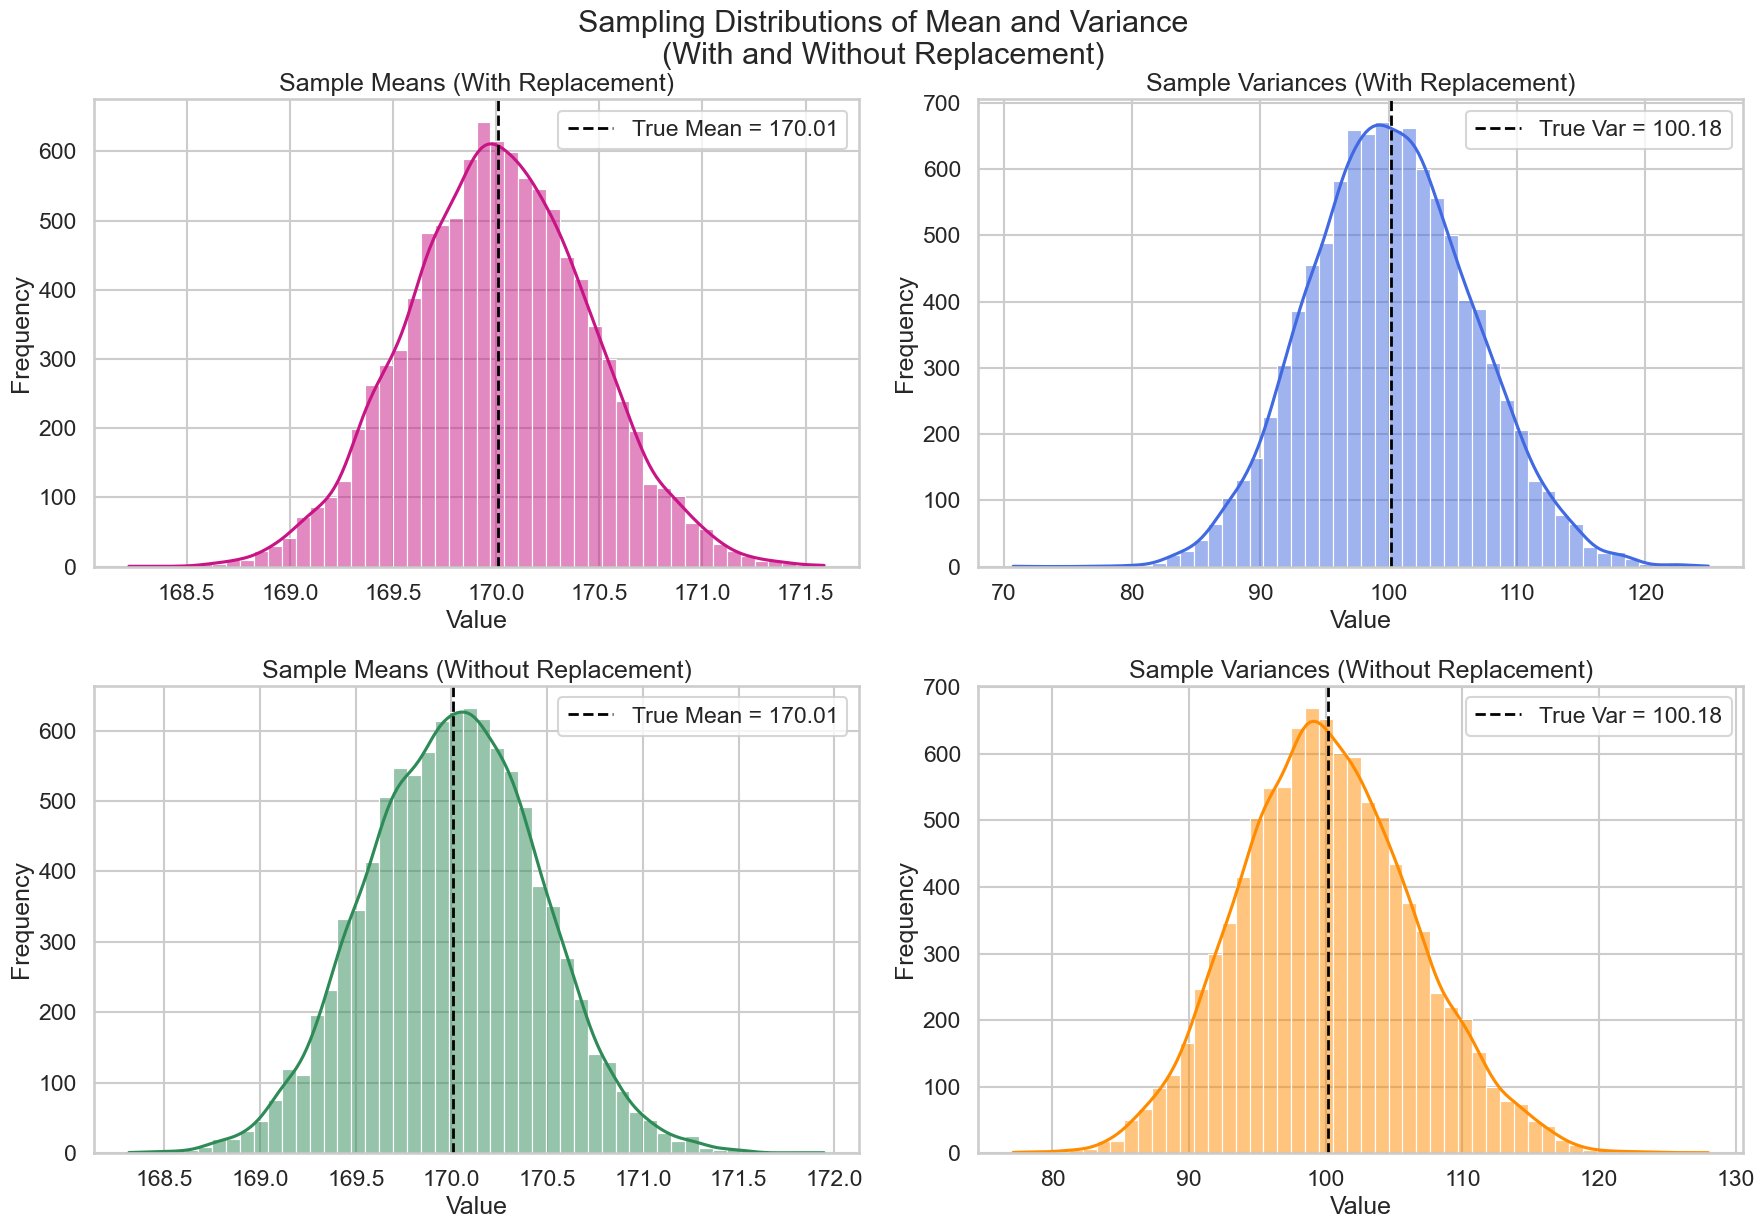

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sparkling style
sns.set(style="whitegrid", palette="bright", context="talk")

# 1. Simulate population
np.random.seed(42)
population_size = 100000
population_height = np.random.normal(loc=170, scale=10, size=population_size)

# Calculate true population parameters
true_mean = np.mean(population_height)
true_variance = np.var(population_height)

# 2. Sampling parameters
sample_size = 500
num_samples = 10000

# 3. Sampling WITH replacement
sample_means_with = []
sample_vars_with = []

for _ in range(num_samples):
    sample = np.random.choice(population_height, size=sample_size, replace=True)
    sample_means_with.append(np.mean(sample))
    sample_vars_with.append(np.var(sample, ddof=1))

# 4. Sampling WITHOUT replacement
sample_means_without = []
sample_vars_without = []

for _ in range(num_samples):
    sample = np.random.choice(population_height, size=sample_size, replace=False)
    sample_means_without.append(np.mean(sample))
    sample_vars_without.append(np.var(sample, ddof=1))

# 5. Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
bins = 50

# First row: WITH replacement
sns.histplot(sample_means_with, bins=bins, kde=True, ax=axes[0, 0], color="mediumvioletred")
axes[0, 0].axvline(true_mean, color='black', linestyle='--', linewidth=2, label=f'True Mean = {true_mean:.2f}')
axes[0, 0].set_title("Sample Means (With Replacement)")
axes[0, 0].legend()

sns.histplot(sample_vars_with, bins=bins, kde=True, ax=axes[0, 1], color="royalblue")
axes[0, 1].axvline(true_variance, color='black', linestyle='--', linewidth=2, label=f'True Var = {true_variance:.2f}')
axes[0, 1].set_title("Sample Variances (With Replacement)")
axes[0, 1].legend()

# Second row: WITHOUT replacement
sns.histplot(sample_means_without, bins=bins, kde=True, ax=axes[1, 0], color="seagreen")
axes[1, 0].axvline(true_mean, color='black', linestyle='--', linewidth=2, label=f'True Mean = {true_mean:.2f}')
axes[1, 0].set_title("Sample Means (Without Replacement)")
axes[1, 0].legend()

sns.histplot(sample_vars_without, bins=bins, kde=True, ax=axes[1, 1], color="darkorange")
axes[1, 1].axvline(true_variance, color='black', linestyle='--', linewidth=2, label=f'True Var = {true_variance:.2f}')
axes[1, 1].set_title("Sample Variances (Without Replacement)")
axes[1, 1].legend()

# Add labels and adjust layout
for ax in axes.flatten():
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Sampling Distributions of Mean and Variance\n(With and Without Replacement)", fontsize=22, y=1.03)
plt.show()


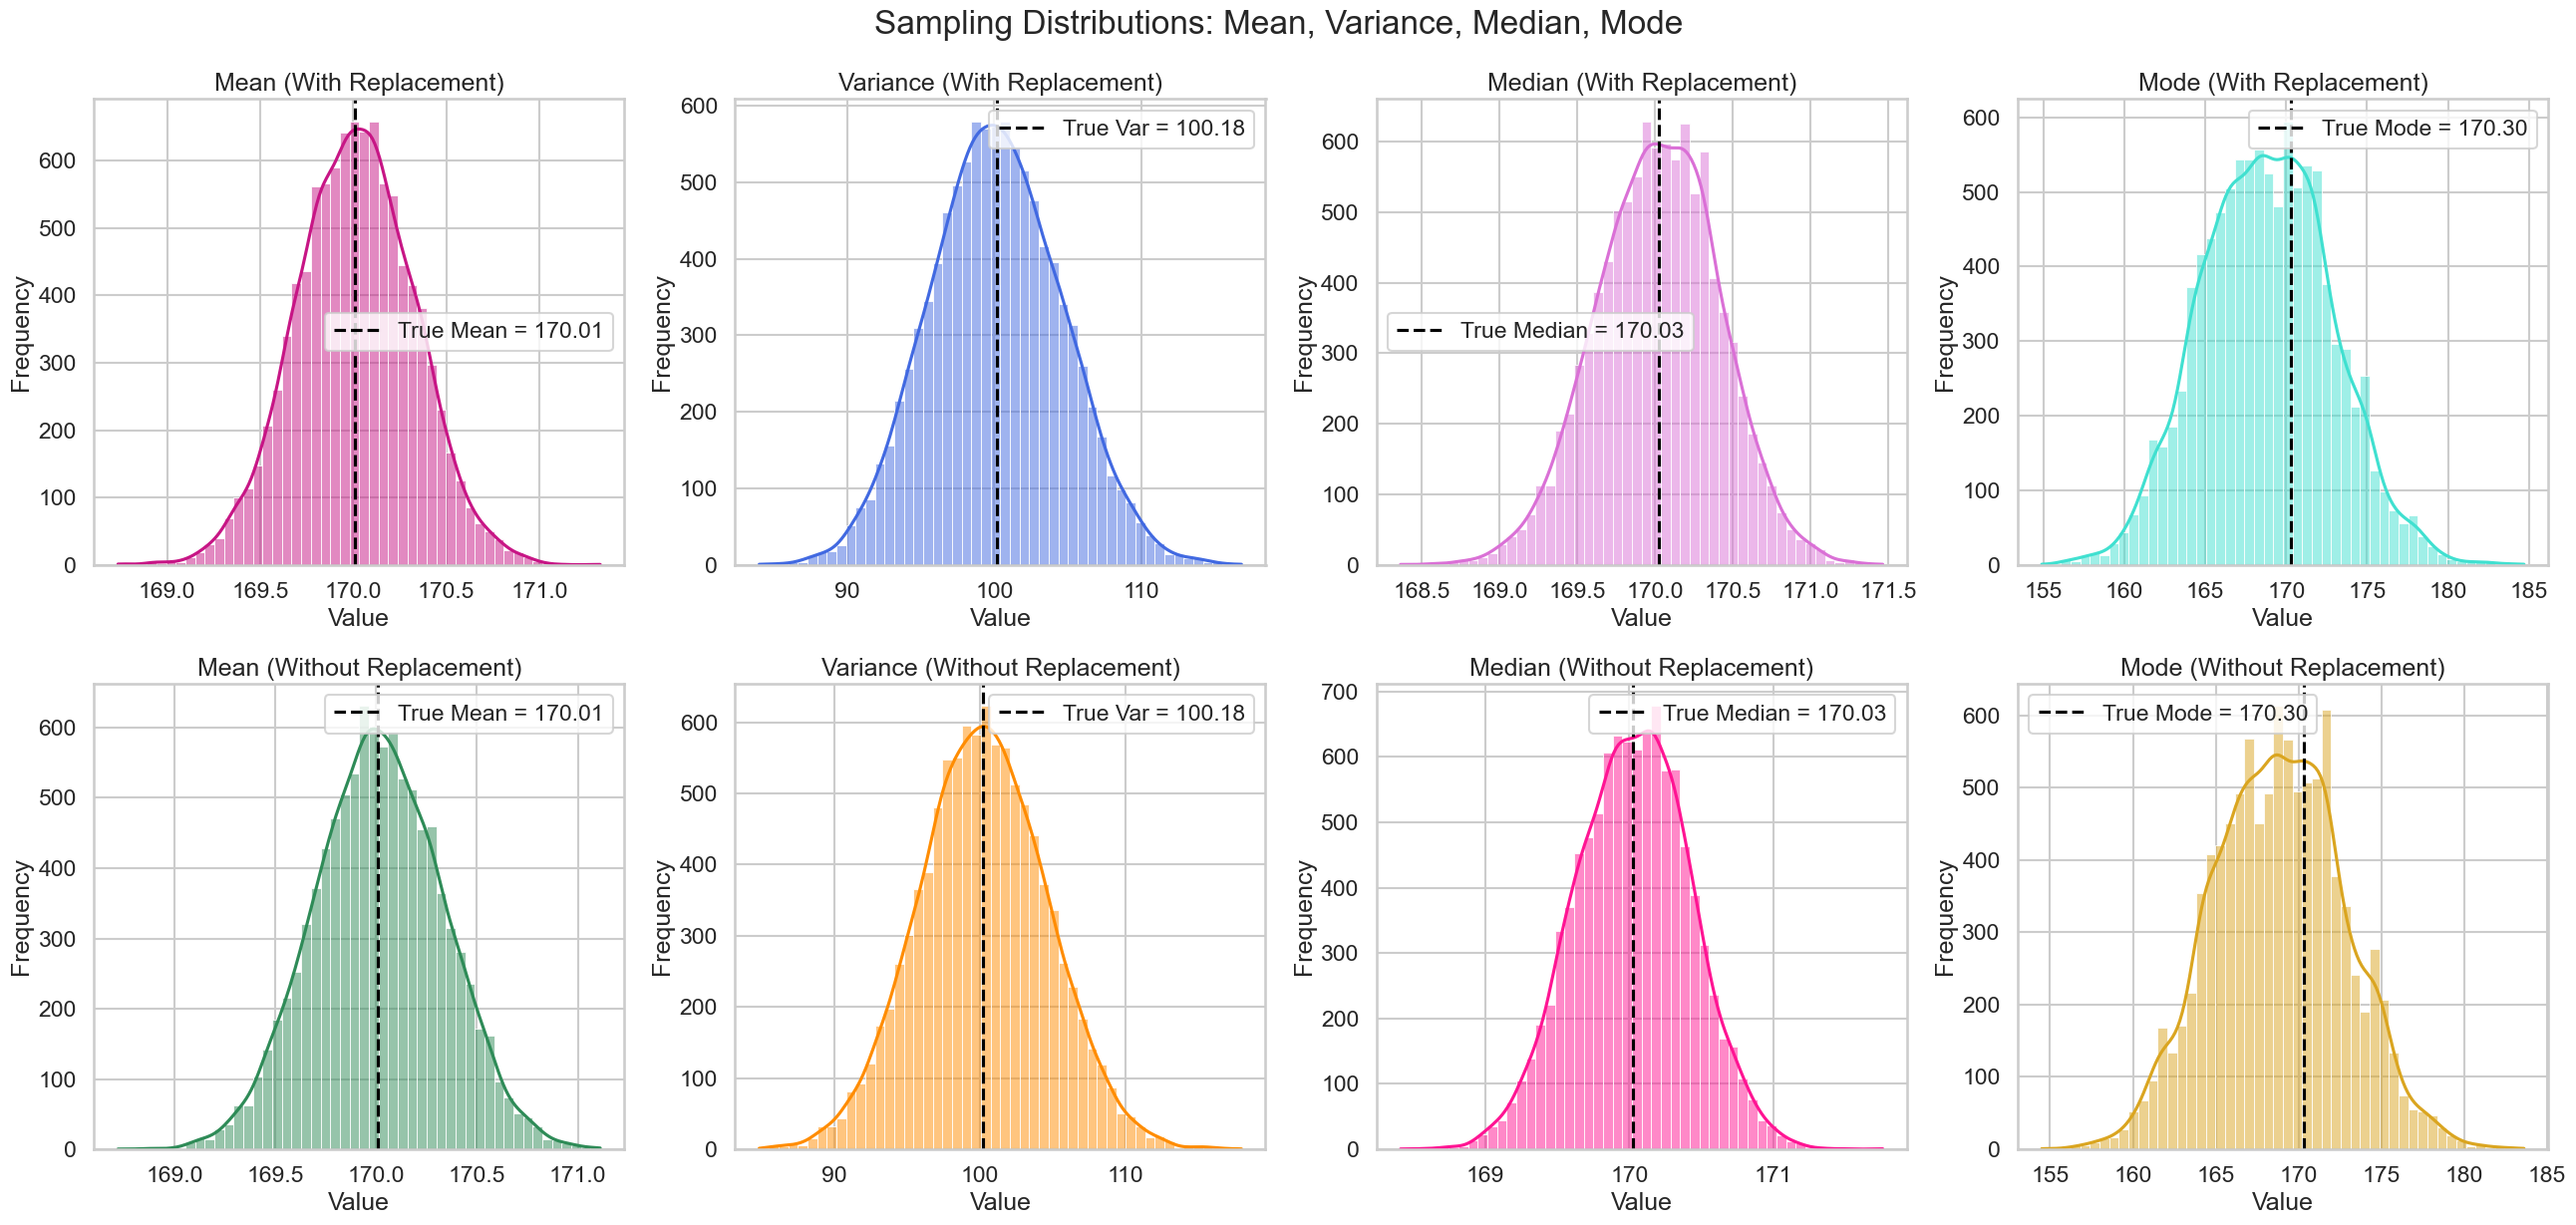

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sparkling style
sns.set(style="whitegrid", palette="bright", context="talk")

# 1. Simulate population
np.random.seed(42)
population_size = 100000
population_height = np.random.normal(loc=170, scale=10, size=population_size)

# Calculate true population parameters
true_mean = np.mean(population_height)
true_variance = np.var(population_height)
true_median = np.median(population_height)
true_mode = stats.mode(np.round(population_height, 1), keepdims=False).mode

# Sampling parameters
sample_size = 1000     #10 #1000   
num_samples = 10000  #500  #5000  #10000
 
# Containers for WITH replacement
sample_means_with = []
sample_vars_with = []
sample_medians_with = []
sample_modes_with = []

# Containers for WITHOUT replacement
sample_means_without = []
sample_vars_without = []
sample_medians_without = []
sample_modes_without = []

# 2. Sampling WITH replacement
for _ in range(num_samples):
    sample = np.random.choice(population_height, size=sample_size, replace=True)
    sample_means_with.append(np.mean(sample))
    sample_vars_with.append(np.var(sample, ddof=1))
    sample_medians_with.append(np.median(sample))
    mode_with = stats.mode(np.round(sample, 1), keepdims=False).mode
    sample_modes_with.append(mode_with)

# 3. Sampling WITHOUT replacement
for _ in range(num_samples):
    sample = np.random.choice(population_height, size=sample_size, replace=False)
    sample_means_without.append(np.mean(sample))
    sample_vars_without.append(np.var(sample, ddof=1))
    sample_medians_without.append(np.median(sample))
    mode_without = stats.mode(np.round(sample, 1), keepdims=False).mode
    sample_modes_without.append(mode_without)

# 4. Plotting
fig, axes = plt.subplots(2, 4, figsize=(26, 12))
bins = 50

# Row 1: With Replacement
sns.histplot(sample_means_with, bins=bins, kde=True, ax=axes[0, 0], color="mediumvioletred")
axes[0, 0].axvline(true_mean, color='black', linestyle='--', label=f'True Mean = {true_mean:.2f}')
axes[0, 0].set_title("Mean (With Replacement)")
axes[0, 0].legend()

sns.histplot(sample_vars_with, bins=bins, kde=True, ax=axes[0, 1], color="royalblue")
axes[0, 1].axvline(true_variance, color='black', linestyle='--', label=f'True Var = {true_variance:.2f}')
axes[0, 1].set_title("Variance (With Replacement)")
axes[0, 1].legend()

sns.histplot(sample_medians_with, bins=bins, kde=True, ax=axes[0, 2], color="orchid")
axes[0, 2].axvline(true_median, color='black', linestyle='--', label=f'True Median = {true_median:.2f}')
axes[0, 2].set_title("Median (With Replacement)")
axes[0, 2].legend()

sns.histplot(sample_modes_with, bins=bins, kde=True, ax=axes[0, 3], color="turquoise")
axes[0, 3].axvline(true_mode, color='black', linestyle='--', label=f'True Mode = {true_mode:.2f}')
axes[0, 3].set_title("Mode (With Replacement)")
axes[0, 3].legend()

# Row 2: Without Replacement
sns.histplot(sample_means_without, bins=bins, kde=True, ax=axes[1, 0], color="seagreen")
axes[1, 0].axvline(true_mean, color='black', linestyle='--', label=f'True Mean = {true_mean:.2f}')
axes[1, 0].set_title("Mean (Without Replacement)")
axes[1, 0].legend()

sns.histplot(sample_vars_without, bins=bins, kde=True, ax=axes[1, 1], color="darkorange")
axes[1, 1].axvline(true_variance, color='black', linestyle='--', label=f'True Var = {true_variance:.2f}')
axes[1, 1].set_title("Variance (Without Replacement)")
axes[1, 1].legend()

sns.histplot(sample_medians_without, bins=bins, kde=True, ax=axes[1, 2], color="deeppink")
axes[1, 2].axvline(true_median, color='black', linestyle='--', label=f'True Median = {true_median:.2f}')
axes[1, 2].set_title("Median (Without Replacement)")
axes[1, 2].legend()

sns.histplot(sample_modes_without, bins=bins, kde=True, ax=axes[1, 3], color="goldenrod")
axes[1, 3].axvline(true_mode, color='black', linestyle='--', label=f'True Mode = {true_mode:.2f}')
axes[1, 3].set_title("Mode (Without Replacement)")
axes[1, 3].legend()

# Add labels and layout
for ax in axes.flatten():
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Sampling Distributions: Mean, Variance, Median, Mode", fontsize=24, y=1.03)
plt.show()


In [1]:

from docx import Document
from docx.shared import Inches

# Crea il documento
doc = Document()
doc.add_heading("Test documento", 0)


# Sezione 1: Descrizione Generale del Dispositivo
doc.add_heading("1. Descrizione Generale del Dispositivo", level=1)
doc.add_paragraph("Descrivere l'applicazione web, le sue funzionalità principali, e il suo scopo clinico.")
doc.add_paragraph("- Nome del dispositivo/software:")
doc.add_paragraph("- Versione del software:")
doc.add_paragraph("- Obiettivo clinico (es. supporto alla fisioterapia post-intervento, riabilitazione, ecc.):")
doc.add_paragraph("- Target di utenza (pazienti, fisioterapisti, medici, ecc.):")

# Sezione 2: Classificazione come Dispositivo Medico
doc.add_heading("2. Classificazione come Dispositivo Medico", level=1)
doc.add_paragraph("Determinare se il software rientra nella definizione di dispositivo medico secondo il Regolamento UE 2017/745 (MDR).")
doc.add_paragraph("- Motivazione della classificazione:")
doc.add_paragraph("- Classe di rischio (I, IIa, IIb, III):")
doc.add_paragraph("- Giustificazione normativa:")

# Sezione 3: Analisi dei Rischi
doc.add_heading("3. Analisi dei Rischi", level=1)
doc.add_paragraph("Eseguire una valutazione dei rischi associati all'uso dell'applicazione.")
doc.add_paragraph("- Metodologia utilizzata (es. ISO 14971):")
doc.add_paragraph("- Identificazione e mitigazione dei rischi principali:")

# Sezione 4: Conformità Normativa
doc.add_heading("4. Conformità Normativa", level=1)
doc.add_paragraph("Elencare le normative e gli standard seguiti.")
doc.add_paragraph("- Regolamento UE 2017/745 (MDR):")
doc.add_paragraph("- ISO 13485 (Sistema di gestione per dispositivi medici):")
doc.add_paragraph("- ISO 14971 (Gestione del rischio):")
doc.add_paragraph("- IEC 62304 (Software medicale):")

# Sezione 5: Protezione dei Dati e GDPR
doc.add_heading("5. Protezione dei Dati e GDPR", level=1)
doc.add_paragraph("Descrivere come vengono gestiti i dati sensibili.")
doc.add_paragraph("- Tipologia di dati raccolti:")
doc.add_paragraph("- Misure di sicurezza (es. crittografia, autenticazione):")
doc.add_paragraph("- Data Protection Impact Assessment (DPIA):")

# Sezione 6: Validazione Clinica
doc.add_heading("6. Validazione Clinica", level=1)
doc.add_paragraph("Descrivere le prove cliniche o l’evidenza scientifica a supporto dell’efficacia dell’applicazione.")
doc.add_paragraph("- Studi pilota o trial clinici condotti:")
doc.add_paragraph("- Collaborazioni con enti sanitari:")
doc.add_paragraph("- Risultati ottenuti:")

# Sezione 7: Processo di Registrazione
doc.add_heading("7. Processo di Registrazione", level=1)
doc.add_paragraph("Descrivere il processo di registrazione presso il Ministero della Salute.")
doc.add_paragraph("- Documentazione presentata:")
doc.add_paragraph("- Numero di registrazione (se disponibile):")

# Salvataggio del file
file_path = "Template_Certificazione_App_Fisioterapica.docx"
doc.save(file_path)

file_path


'Template_Certificazione_App_Fisioterapica.docx'